In [1]:
import seaborn as sns

sns.set_style("darkgrid")

In [2]:
import pandas_datareader as pdr

ds = pdr.data.DataReader('5_Industry_Portfolios_daily', 'famafrench')

In [3]:
print(ds['DESCR'])

5 Industry Portfolios daily
---------------------------

This file was created by CMPT_IND_RETS_DAILY using the 202108 CRSP database. It contains value- and equal-weighted returns for 5 industry portfolios. The portfolios are constructed at the end of June. Missing data are indicated by -99.99 or -999. Copyright 2021 Kenneth R. French

  0 : Average Value Weighted Returns -- Daily (1227 rows x 5 cols)
  1 : Average Equal Weighted Returns -- Daily (1227 rows x 5 cols)


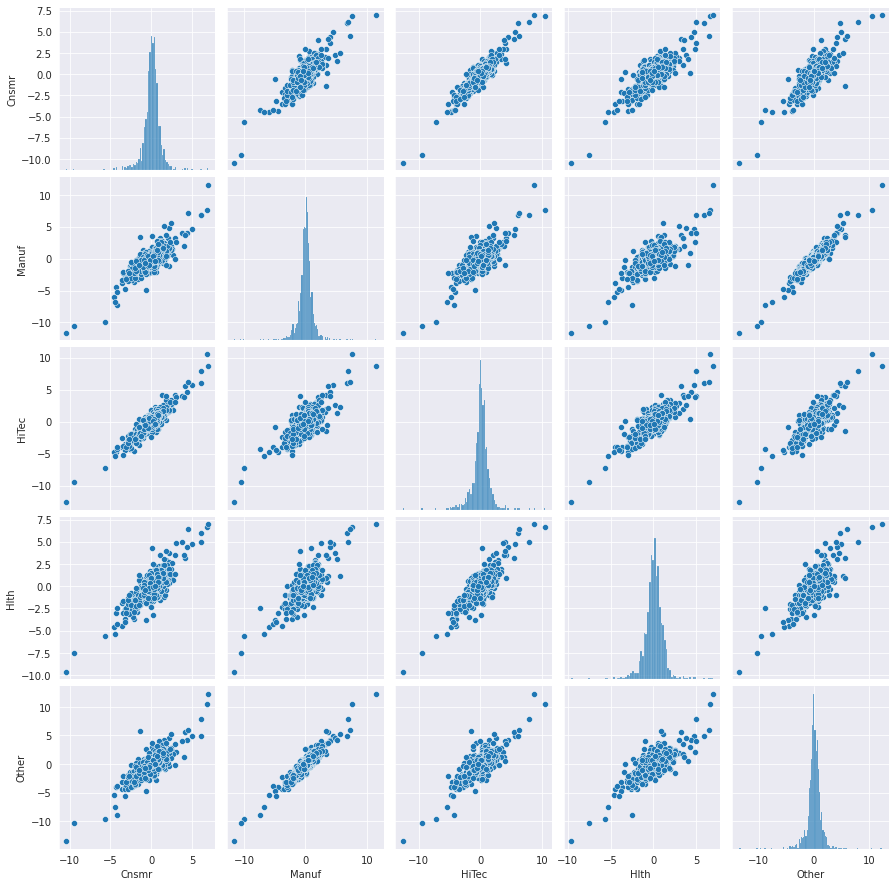

In [4]:
sns.pairplot(data=ds[0])

In [66]:
import flowtorch.bijectors
import flowtorch.parameters
import flowtorch.distributions as fdist

import torch
import torch.distributions as dist
import torch.optim

from tqdm.auto import tqdm

def fit_pq(flow, opt, num_epochs, retain_graph=False, loss_every=100, **kwargs):
    losses = []
    for it in tqdm(range(num_epochs)):
        opt.zero_grad()
        nll = None
        while not nll:
            try:
                nll = -flow.log_prob(torch.tensor(ds[0].to_numpy()).float()).mean()
            except ValueError:
                continue
        if it % loss_every == 0:
            tqdm.write(f"neg log lik: {nll}")
            losses.append(nll.item()) 
        nll.backward(retain_graph=retain_graph)
        opt.step()
    return losses

    
def train_advi(lr=5e-3, num_epochs=1_000, **kwargs):
    advi_flow = fdist.Flow(
    dist.Independent(dist.Normal(torch.zeros(5), torch.ones(5)), 1),
        flowtorch.bijectors.AffineAutoregressive(
            params=flowtorch.parameters.DenseAutoregressive(hidden_dims=(64,64)),
        )
    )
    advi_params = advi_flow.parameters()
    return fit_pq(advi_flow, torch.optim.Adam(advi_flow.parameters(), lr=lr), num_epochs=num_epochs, **kwargs), advi_flow, None

In [67]:
import torch.nn as nn


def train_taf(lr=5e-3, nu_init=4, num_epochs=1_000, **kwargs):
    taf_nu = nn.Parameter(torch.ones(1)*nu_init, requires_grad=True)
    taf_flow = fdist.Flow(
        dist.Independent(dist.StudentT(df=taf_nu.exp() * torch.ones(5)), 1),
        flowtorch.bijectors.AffineAutoregressive(
            params=flowtorch.parameters.DenseAutoregressive(hidden_dims=(64,64)),
        )
    )
    taf_params = list(taf_flow.parameters()) + [taf_nu]
    taf_opt = torch.optim.Adam(taf_params, lr=lr)
    return fit_pq(taf_flow, taf_opt, num_epochs, retain_graph=True, **kwargs), taf_flow, taf_nu

In [68]:
import torch.nn as nn

def train_ataf(lr=5e-3, nu_init=4, num_epochs=1_000, **kwargs):
    ftvi_nu = nn.Parameter(torch.ones(5)*nu_init, requires_grad=True)

    ftvi_flow = fdist.Flow(
        dist.Independent(dist.StudentT(df=ftvi_nu.exp()), 1),
        flowtorch.bijectors.AffineAutoregressive(
            params=flowtorch.parameters.DenseAutoregressive(hidden_dims=(64,64)),
        )
    )
    params = list(ftvi_flow.parameters()) + [ftvi_nu]
    opt = torch.optim.Adam(params, lr=lr)

    return fit_pq(ftvi_flow, opt, num_epochs, retain_graph=True, **kwargs), ftvi_flow, ftvi_nu

In [69]:
all_losses = []
all_samples = []

num_trials = 10
loss_every = 100
for trial in tqdm(range(num_trials)):
    losses = {}
    samples = {}
    for (name, train_fn) in [
        ('advi', train_advi),
        ('taf', train_taf),
        ('ataf', train_ataf),
    ]:
        tqdm.write(f"method: {name}")
        loss, flow, nu = train_fn(lr=2e-3, nu_init=torch.log(torch.tensor(4.)), num_epochs=5_000, loss_every=loss_every)
        tqdm.write(f"nu: {nu}")
        losses[name] = loss
        samples[name] = flow.sample((ds[0].shape[0],))
    all_losses.append(losses)
    all_samples.append(samples)

  0%|          | 0/10 [00:00<?, ?it/s]

method: advi


  0%|          | 0/5000 [00:00<?, ?it/s]

neg log lik: 8.60678482055664
neg log lik: 5.329999923706055
neg log lik: 4.9392547607421875
neg log lik: 4.865184307098389
neg log lik: 4.795915603637695
neg log lik: 4.722975730895996
neg log lik: 4.804143905639648
neg log lik: 4.649857044219971
neg log lik: 4.620906829833984
neg log lik: 4.64523458480835
neg log lik: 4.590237617492676
neg log lik: 4.979560375213623
neg log lik: 4.624002933502197
neg log lik: 4.588795185089111
neg log lik: 4.581407070159912
neg log lik: 4.6095123291015625
neg log lik: 4.619709491729736
neg log lik: 4.694662094116211
neg log lik: 4.613728046417236
neg log lik: 4.543271541595459
neg log lik: 4.520836353302002
neg log lik: 4.517447471618652
neg log lik: 4.604138374328613
neg log lik: 4.586148262023926
neg log lik: 4.511167049407959
neg log lik: 4.587942123413086
neg log lik: 4.476436614990234
neg log lik: 4.586556911468506
neg log lik: 4.476419925689697
neg log lik: 4.510934352874756
neg log lik: 4.5205278396606445
neg log lik: 4.457099914550781
neg log

  0%|          | 0/5000 [00:00<?, ?it/s]

neg log lik: 7.6600494384765625
neg log lik: 4.992749214172363
neg log lik: 4.655699729919434
neg log lik: 4.547737121582031
neg log lik: 4.483578205108643
neg log lik: 4.439756870269775
neg log lik: 4.406583786010742
neg log lik: 4.375280857086182
neg log lik: 4.350111484527588
neg log lik: 4.334018230438232
neg log lik: 4.331150054931641
neg log lik: 4.284659385681152
neg log lik: 4.288813591003418
neg log lik: 4.277952671051025
neg log lik: 4.279539108276367
neg log lik: 4.248013973236084
neg log lik: 4.248624324798584
neg log lik: 4.221284866333008
neg log lik: 4.208858013153076
neg log lik: 4.210770130157471
neg log lik: 4.2057647705078125
neg log lik: 4.19640588760376
neg log lik: 4.172505855560303
neg log lik: 4.170345783233643
neg log lik: 4.1854376792907715
neg log lik: 4.197002410888672
neg log lik: 4.1549859046936035
neg log lik: 4.141641139984131
neg log lik: 4.1461992263793945
neg log lik: 4.13652229309082
neg log lik: 4.136500835418701
neg log lik: 4.143688678741455
neg l

  0%|          | 0/5000 [00:00<?, ?it/s]

neg log lik: 7.579530715942383
neg log lik: 4.77164888381958
neg log lik: 4.622774124145508
neg log lik: 4.547194004058838
neg log lik: 4.48802375793457
neg log lik: 4.451977252960205
neg log lik: 4.417078495025635
neg log lik: 4.395868301391602
neg log lik: 4.380971431732178
neg log lik: 4.368901252746582
neg log lik: 4.35090446472168
neg log lik: 4.332828044891357
neg log lik: 4.328260898590088
neg log lik: 4.325120449066162
neg log lik: 4.314936637878418
neg log lik: 4.2862868309021
neg log lik: 4.285455703735352
neg log lik: 4.294092655181885
neg log lik: 4.251092910766602
neg log lik: 4.2747111320495605
neg log lik: 4.260782241821289
neg log lik: 4.22963285446167
neg log lik: 4.253520488739014
neg log lik: 4.2325921058654785
neg log lik: 4.22384786605835
neg log lik: 4.2303314208984375
neg log lik: 4.263566493988037
neg log lik: 4.221211910247803
neg log lik: 4.230992317199707
neg log lik: 4.205048084259033
neg log lik: 4.20961332321167
neg log lik: 4.201969623565674
neg log lik: 

  0%|          | 0/5000 [00:00<?, ?it/s]

neg log lik: 8.668071746826172
neg log lik: 5.272814750671387
neg log lik: 4.981750965118408
neg log lik: 4.902997016906738
neg log lik: 4.833532810211182
neg log lik: 4.769531726837158
neg log lik: 4.722451686859131
neg log lik: 4.6845831871032715
neg log lik: 4.665393352508545
neg log lik: 4.624673366546631
neg log lik: 4.805348873138428
neg log lik: 4.6603803634643555
neg log lik: 4.608882427215576
neg log lik: 4.580326557159424
neg log lik: 4.574997425079346
neg log lik: 4.5822038650512695
neg log lik: 4.557667255401611
neg log lik: 4.525299549102783
neg log lik: 4.552536964416504
neg log lik: 4.521310806274414
neg log lik: 4.595663070678711
neg log lik: 4.497814655303955
neg log lik: 4.499832630157471
neg log lik: 4.46626615524292
neg log lik: 4.624250411987305
neg log lik: 4.506317138671875
neg log lik: 4.483285427093506
neg log lik: 4.489814758300781
neg log lik: 4.548600196838379
neg log lik: 4.449272155761719
neg log lik: 4.67056941986084
neg log lik: 4.521740913391113
neg log

  0%|          | 0/5000 [00:00<?, ?it/s]

neg log lik: 7.5625810623168945
neg log lik: 4.8421549797058105
neg log lik: 4.621509075164795
neg log lik: 4.5388875007629395
neg log lik: 4.489664077758789
neg log lik: 4.453787803649902
neg log lik: 4.432900428771973
neg log lik: 4.399353504180908
neg log lik: 4.385462284088135
neg log lik: 4.373150825500488
neg log lik: 4.344410419464111
neg log lik: 4.340586185455322
neg log lik: 4.328080177307129
neg log lik: 4.317677974700928
neg log lik: 4.331040382385254
neg log lik: 4.318167209625244
neg log lik: 4.302178859710693
neg log lik: 4.291370868682861
neg log lik: 4.291368007659912
neg log lik: 4.280401229858398
neg log lik: 4.247671604156494
neg log lik: 4.26171875
neg log lik: 4.25281286239624
neg log lik: 4.227027893066406
neg log lik: 4.245625972747803
neg log lik: 4.245236396789551
neg log lik: 4.207982540130615
neg log lik: 4.195781707763672
neg log lik: 4.206900119781494
neg log lik: 4.221356391906738
neg log lik: 4.177974700927734
neg log lik: 4.169570446014404
neg log lik: 

  0%|          | 0/5000 [00:00<?, ?it/s]

neg log lik: 7.607208728790283
neg log lik: 4.78509521484375
neg log lik: 4.634012222290039
neg log lik: 4.54935884475708
neg log lik: 4.488697528839111
neg log lik: 4.446725368499756
neg log lik: 4.431178092956543
neg log lik: 4.394465923309326
neg log lik: 4.3778581619262695
neg log lik: 4.359081268310547
neg log lik: 4.33642053604126
neg log lik: 4.337423324584961
neg log lik: 4.321168422698975
neg log lik: 4.297760963439941
neg log lik: 4.289953231811523
neg log lik: 4.275728225708008
neg log lik: 4.262478351593018
neg log lik: 4.26015043258667
neg log lik: 4.251420021057129
neg log lik: 4.249096870422363
neg log lik: 4.238902568817139
neg log lik: 4.227322578430176
neg log lik: 4.20137357711792
neg log lik: 4.22420072555542
neg log lik: 4.203246593475342
neg log lik: 4.19695520401001
neg log lik: 4.176121711730957
neg log lik: 4.182182788848877
neg log lik: 4.162966251373291
neg log lik: 4.206969738006592
neg log lik: 4.160700798034668
neg log lik: 4.1750078201293945
neg log lik: 

  0%|          | 0/5000 [00:00<?, ?it/s]

neg log lik: 10.406234741210938
neg log lik: 5.364297389984131
neg log lik: 4.903769016265869
neg log lik: 4.806881427764893
neg log lik: 4.758736610412598
neg log lik: 4.729780673980713
neg log lik: 4.701871871948242
neg log lik: 4.675690650939941
neg log lik: 4.701045036315918
neg log lik: 4.7344465255737305
neg log lik: 4.627890110015869
neg log lik: 4.599381923675537
neg log lik: 4.705121040344238
neg log lik: 4.7490668296813965
neg log lik: 4.571594715118408
neg log lik: 4.558328151702881
neg log lik: 4.651421546936035
neg log lik: 4.539248943328857
neg log lik: 4.5333943367004395
neg log lik: 4.58082914352417
neg log lik: 4.536489963531494
neg log lik: 4.514517307281494
neg log lik: 4.526454925537109
neg log lik: 4.540919780731201
neg log lik: 4.498037338256836
neg log lik: 4.530481338500977
neg log lik: 4.49472188949585
neg log lik: 4.483267307281494
neg log lik: 4.481088161468506
neg log lik: 4.497396469116211
neg log lik: 4.4849934577941895
neg log lik: 4.6097917556762695
neg 

  0%|          | 0/5000 [00:00<?, ?it/s]

neg log lik: 7.569515228271484
neg log lik: 4.808297634124756
neg log lik: 4.65710973739624
neg log lik: 4.5932297706604
neg log lik: 4.536893844604492
neg log lik: 4.489034652709961
neg log lik: 4.4596734046936035
neg log lik: 4.426915168762207
neg log lik: 4.406771659851074
neg log lik: 4.412387371063232
neg log lik: 4.383419990539551
neg log lik: 4.366602897644043
neg log lik: 4.37160587310791
neg log lik: 4.362033843994141
neg log lik: 4.335788726806641
neg log lik: 4.3382649421691895
neg log lik: 4.313267230987549
neg log lik: 4.2971649169921875
neg log lik: 4.282242298126221
neg log lik: 4.305063724517822
neg log lik: 4.2750396728515625
neg log lik: 4.266696929931641
neg log lik: 4.2470831871032715
neg log lik: 4.249456882476807
neg log lik: 4.2459306716918945
neg log lik: 4.235347747802734
neg log lik: 4.227775573730469
neg log lik: 4.21237325668335
neg log lik: 4.261250019073486
neg log lik: 4.210095405578613
neg log lik: 4.209454536437988
neg log lik: 4.185182571411133
neg log

  0%|          | 0/5000 [00:00<?, ?it/s]

neg log lik: 7.597169399261475
neg log lik: 4.800851821899414
neg log lik: 4.625877857208252
neg log lik: 4.5654520988464355
neg log lik: 4.504868030548096
neg log lik: 4.465097427368164
neg log lik: 4.438731670379639
neg log lik: 4.414802074432373
neg log lik: 4.386392593383789
neg log lik: 4.377351760864258
neg log lik: 4.3627028465271
neg log lik: 4.346447944641113
neg log lik: 4.373497009277344
neg log lik: 4.326547622680664
neg log lik: 4.311161994934082
neg log lik: 4.2976579666137695
neg log lik: 4.316103458404541
neg log lik: 4.290003776550293
neg log lik: 4.318140506744385
neg log lik: 4.290332794189453
neg log lik: 4.305727958679199
neg log lik: 4.2780842781066895
neg log lik: 4.285242080688477
neg log lik: 4.265122413635254
neg log lik: 4.304523944854736
neg log lik: 4.27228307723999
neg log lik: 4.248579025268555
neg log lik: 4.25722599029541
neg log lik: 4.293803691864014
neg log lik: 4.243903636932373
neg log lik: 4.238131523132324
neg log lik: 4.226790428161621
neg log l

  0%|          | 0/5000 [00:00<?, ?it/s]

neg log lik: 9.335138320922852
neg log lik: 5.494208812713623
neg log lik: 4.948068618774414
neg log lik: 4.862438201904297
neg log lik: 4.800320625305176
neg log lik: 4.7480387687683105
neg log lik: 4.7223992347717285
neg log lik: 4.660062313079834
neg log lik: 4.641058444976807
neg log lik: 4.639918327331543
neg log lik: 4.590908050537109
neg log lik: 4.633218288421631
neg log lik: 4.559981822967529
neg log lik: 4.804369926452637
neg log lik: 4.644705772399902
neg log lik: 4.5693793296813965
neg log lik: 4.5475029945373535
neg log lik: 4.585624694824219
neg log lik: 4.526447772979736
neg log lik: 4.509361267089844
neg log lik: 4.572993278503418
neg log lik: 4.492597579956055
neg log lik: 4.488212585449219
neg log lik: 4.475863933563232
neg log lik: 4.44874382019043
neg log lik: 4.460245609283447
neg log lik: 4.431595325469971
neg log lik: 4.4441680908203125
neg log lik: 4.420408248901367
neg log lik: 4.42150354385376
neg log lik: 4.424810886383057
neg log lik: 4.40516996383667
neg lo

  0%|          | 0/5000 [00:00<?, ?it/s]

neg log lik: 7.727304458618164
neg log lik: 4.777472019195557
neg log lik: 4.610412120819092
neg log lik: 4.544579029083252
neg log lik: 4.4992194175720215
neg log lik: 4.463750839233398
neg log lik: 4.430594444274902
neg log lik: 4.40350341796875
neg log lik: 4.382457733154297
neg log lik: 4.359703063964844
neg log lik: 4.34503698348999
neg log lik: 4.322338104248047
neg log lik: 4.330567836761475
neg log lik: 4.321088790893555
neg log lik: 4.290668487548828
neg log lik: 4.275840759277344
neg log lik: 4.303411483764648
neg log lik: 4.265205383300781
neg log lik: 4.258857727050781
neg log lik: 4.246424198150635
neg log lik: 4.254012107849121
neg log lik: 4.255589485168457
neg log lik: 4.243735313415527
neg log lik: 4.2271504402160645
neg log lik: 4.216087341308594
neg log lik: 4.267360210418701
neg log lik: 4.206645965576172
neg log lik: 4.225503921508789
neg log lik: 4.20368766784668
neg log lik: 4.209194183349609
neg log lik: 4.194671630859375
neg log lik: 4.174675464630127
neg log l

  0%|          | 0/5000 [00:00<?, ?it/s]

neg log lik: 7.591274738311768
neg log lik: 4.845218658447266
neg log lik: 4.636817455291748
neg log lik: 4.559967517852783
neg log lik: 4.506472110748291
neg log lik: 4.441233158111572
neg log lik: 4.423702716827393
neg log lik: 4.390072822570801
neg log lik: 4.359055519104004
neg log lik: 4.354280471801758
neg log lik: 4.334523677825928
neg log lik: 4.3071513175964355
neg log lik: 4.289078235626221
neg log lik: 4.280470848083496
neg log lik: 4.267507553100586
neg log lik: 4.270603179931641
neg log lik: 4.248933792114258
neg log lik: 4.237518310546875
neg log lik: 4.229320526123047
neg log lik: 4.227774143218994
neg log lik: 4.207895755767822
neg log lik: 4.191766738891602
neg log lik: 4.201688766479492
neg log lik: 4.208007335662842
neg log lik: 4.196390151977539
neg log lik: 4.1940107345581055
neg log lik: 4.163917541503906
neg log lik: 4.1990251541137695
neg log lik: 4.1652727127075195
neg log lik: 4.155838966369629
neg log lik: 4.172213077545166
neg log lik: 4.154435634613037
neg 

  0%|          | 0/5000 [00:00<?, ?it/s]

neg log lik: 9.7047700881958
neg log lik: 5.379483699798584
neg log lik: 5.02157735824585
neg log lik: 4.953787326812744
neg log lik: 4.89968204498291
neg log lik: 4.849088191986084
neg log lik: 4.810466289520264
neg log lik: 4.809107303619385
neg log lik: 4.749094009399414
neg log lik: 4.7309184074401855
neg log lik: 4.703115940093994
neg log lik: 4.681591987609863
neg log lik: 4.680327892303467
neg log lik: 4.683070182800293
neg log lik: 4.673510551452637
neg log lik: 4.62615966796875
neg log lik: 4.67324161529541
neg log lik: 4.612343788146973
neg log lik: 4.698884963989258
neg log lik: 4.603878498077393
neg log lik: 4.584373474121094
neg log lik: 4.5618462562561035
neg log lik: 4.6636199951171875
neg log lik: 4.544092655181885
neg log lik: 7.05654764175415
neg log lik: 5.8429412841796875
neg log lik: 5.52763032913208
neg log lik: 5.28309965133667
neg log lik: 5.086202621459961
neg log lik: 4.965665340423584
neg log lik: 4.836373805999756
neg log lik: 4.8006134033203125
neg log lik:

  0%|          | 0/5000 [00:00<?, ?it/s]

neg log lik: 7.613978385925293
neg log lik: 4.801075458526611
neg log lik: 4.630568981170654
neg log lik: 4.562364101409912
neg log lik: 4.516611099243164
neg log lik: 4.4818878173828125
neg log lik: 4.434779644012451
neg log lik: 4.421140193939209
neg log lik: 4.392226219177246
neg log lik: 4.375628471374512
neg log lik: 4.3599700927734375
neg log lik: 4.349522590637207
neg log lik: 4.350159645080566
neg log lik: 4.3451080322265625
neg log lik: 4.323105812072754
neg log lik: 4.300980567932129
neg log lik: 4.2865214347839355
neg log lik: 4.3040452003479
neg log lik: 4.302621841430664
neg log lik: 4.25738525390625
neg log lik: 4.288569927215576
neg log lik: 4.25515079498291
neg log lik: 4.2571330070495605
neg log lik: 4.265185356140137
neg log lik: 4.247122764587402
neg log lik: 4.266993045806885
neg log lik: 4.246368408203125
neg log lik: 4.285078048706055
neg log lik: 4.218080997467041
neg log lik: 4.228729724884033
neg log lik: 4.236077308654785
neg log lik: 4.2308502197265625
neg lo

  0%|          | 0/5000 [00:00<?, ?it/s]

neg log lik: 7.514692306518555
neg log lik: 4.860454082489014
neg log lik: 4.635858535766602
neg log lik: 4.553563117980957
neg log lik: 4.49080228805542
neg log lik: 4.439321994781494
neg log lik: 4.404287338256836
neg log lik: 4.365149974822998
neg log lik: 4.3609466552734375
neg log lik: 4.305632591247559
neg log lik: 4.2984747886657715
neg log lik: 4.279562950134277
neg log lik: 4.2602739334106445
neg log lik: 4.260964393615723
neg log lik: 4.2727813720703125
neg log lik: 4.248946189880371
neg log lik: 4.249326705932617
neg log lik: 4.244266986846924
neg log lik: 4.227906227111816
neg log lik: 4.2147440910339355
neg log lik: 4.231949806213379
neg log lik: 4.218783378601074
neg log lik: 4.214797019958496
neg log lik: 4.215723037719727
neg log lik: 4.190552234649658
neg log lik: 4.19932222366333
neg log lik: 4.175304889678955
neg log lik: 4.206308364868164
neg log lik: 4.183145523071289
neg log lik: 4.203726768493652
neg log lik: 4.180013656616211
neg log lik: 4.167653560638428
neg l

  0%|          | 0/5000 [00:00<?, ?it/s]

neg log lik: 9.036857604980469
neg log lik: 5.282630443572998
neg log lik: 4.995396137237549
neg log lik: 4.912930965423584
neg log lik: 4.854870796203613
neg log lik: 4.816072940826416
neg log lik: 4.81801176071167
neg log lik: 4.768809795379639
neg log lik: 4.7397332191467285
neg log lik: 4.733979225158691
neg log lik: 4.735224723815918
neg log lik: 4.709056854248047
neg log lik: 4.667622089385986
neg log lik: 4.6631760597229
neg log lik: 4.655561447143555
neg log lik: 4.671652317047119
neg log lik: 4.629264831542969
neg log lik: 4.594037055969238
neg log lik: 4.6288251876831055
neg log lik: 4.572005271911621
neg log lik: 4.664589881896973
neg log lik: 4.555212020874023
neg log lik: 4.5608367919921875
neg log lik: 4.602471828460693
neg log lik: 4.551835536956787
neg log lik: 4.5536370277404785
neg log lik: 4.537524700164795
neg log lik: 4.505331516265869
neg log lik: 4.5404205322265625
neg log lik: 4.481775283813477
neg log lik: 4.972391605377197
neg log lik: 4.547081470489502
neg lo

  0%|          | 0/5000 [00:00<?, ?it/s]

neg log lik: 7.676089286804199
neg log lik: 4.846757411956787
neg log lik: 4.633489608764648
neg log lik: 4.562137603759766
neg log lik: 4.511324882507324
neg log lik: 4.478645324707031
neg log lik: 4.452343463897705
neg log lik: 4.42476224899292
neg log lik: 4.401205062866211
neg log lik: 4.391790390014648
neg log lik: 4.376107215881348
neg log lik: 4.366452693939209
neg log lik: 4.351390361785889
neg log lik: 4.337838172912598
neg log lik: 4.324304103851318
neg log lik: 4.299339294433594
neg log lik: 4.283685207366943
neg log lik: 4.278687953948975
neg log lik: 4.268393516540527
neg log lik: 4.262206077575684
neg log lik: 4.244412422180176
neg log lik: 4.240858554840088
neg log lik: 4.261937618255615
neg log lik: 4.2369842529296875
neg log lik: 4.229959964752197
neg log lik: 4.199380874633789
neg log lik: 4.225399017333984
neg log lik: 4.205975532531738
neg log lik: 4.186159133911133
neg log lik: 4.18463659286499
neg log lik: 4.174471378326416
neg log lik: 4.173873424530029
neg log l

  0%|          | 0/5000 [00:00<?, ?it/s]

neg log lik: 7.515495300292969
neg log lik: 5.057765960693359
neg log lik: 4.63542366027832
neg log lik: 4.563260555267334
neg log lik: 4.5094780921936035
neg log lik: 4.461163520812988
neg log lik: 4.421058177947998
neg log lik: 4.390569686889648
neg log lik: 4.395540237426758
neg log lik: 4.354938507080078
neg log lik: 4.330377578735352
neg log lik: 4.311961650848389
neg log lik: 4.302633762359619
neg log lik: 4.30859899520874
neg log lik: 4.265730857849121
neg log lik: 4.258285999298096
neg log lik: 4.27741003036499
neg log lik: 4.24601936340332
neg log lik: 4.258771896362305
neg log lik: 4.25458288192749
neg log lik: 4.193307876586914
neg log lik: 4.199484348297119
neg log lik: 4.216136455535889
neg log lik: 4.18820858001709
neg log lik: 4.173587322235107
neg log lik: 4.154421806335449
neg log lik: 4.193996906280518
neg log lik: 4.173638820648193
neg log lik: 4.1615800857543945
neg log lik: 4.162221908569336
neg log lik: 4.152164936065674
neg log lik: 4.134677886962891
neg log lik:

  0%|          | 0/5000 [00:00<?, ?it/s]

neg log lik: 8.749892234802246
neg log lik: 5.292007923126221
neg log lik: 4.955648899078369
neg log lik: 4.868495941162109
neg log lik: 4.796274662017822
neg log lik: 4.733231544494629
neg log lik: 4.666197299957275
neg log lik: 4.644049644470215
neg log lik: 4.634152889251709
neg log lik: 4.5799665451049805
neg log lik: 4.561666488647461
neg log lik: 4.543778896331787
neg log lik: 4.5258469581604
neg log lik: 4.502431392669678
neg log lik: 4.5073676109313965
neg log lik: 4.471122741699219
neg log lik: 4.533060550689697
neg log lik: 4.467884540557861
neg log lik: 4.444807052612305
neg log lik: 4.441645622253418
neg log lik: 4.463842868804932
neg log lik: 4.416798114776611
neg log lik: 4.4215898513793945
neg log lik: 4.421391487121582
neg log lik: 4.392721652984619
neg log lik: 4.379908084869385
neg log lik: 4.4426093101501465
neg log lik: 4.357158660888672
neg log lik: 4.358678817749023
neg log lik: 4.530410289764404
neg log lik: 4.40099573135376
neg log lik: 4.386578559875488
neg log

  0%|          | 0/5000 [00:00<?, ?it/s]

neg log lik: 7.5555853843688965
neg log lik: 4.868884086608887
neg log lik: 4.632987022399902
neg log lik: 4.562686920166016
neg log lik: 4.519871711730957
neg log lik: 4.483185291290283
neg log lik: 4.456142425537109
neg log lik: 4.431540012359619
neg log lik: 4.411363124847412
neg log lik: 4.3896355628967285
neg log lik: 4.363669395446777
neg log lik: 4.336920261383057
neg log lik: 4.325148582458496
neg log lik: 4.311051845550537
neg log lik: 4.315942764282227
neg log lik: 4.3086113929748535
neg log lik: 4.3000874519348145
neg log lik: 4.269211292266846
neg log lik: 4.267483234405518
neg log lik: 4.24815034866333
neg log lik: 4.26910924911499
neg log lik: 4.244587421417236
neg log lik: 4.23631477355957
neg log lik: 4.25060510635376
neg log lik: 4.230246067047119
neg log lik: 4.220935821533203
neg log lik: 4.2263102531433105
neg log lik: 4.209106922149658
neg log lik: 4.210853099822998
neg log lik: 4.216450214385986
neg log lik: 4.197196960449219
neg log lik: 4.208245754241943
neg log

  0%|          | 0/5000 [00:00<?, ?it/s]

neg log lik: 7.58704948425293
neg log lik: 4.783414363861084
neg log lik: 4.625123023986816
neg log lik: 4.556213855743408
neg log lik: 4.511979579925537
neg log lik: 4.479092121124268
neg log lik: 4.451502799987793
neg log lik: 4.428414821624756
neg log lik: 4.41325569152832
neg log lik: 4.412807941436768
neg log lik: 4.3858561515808105
neg log lik: 4.367094993591309
neg log lik: 4.339930057525635
neg log lik: 4.33833646774292
neg log lik: 4.320969104766846
neg log lik: 4.3265557289123535
neg log lik: 4.315466403961182
neg log lik: 4.2963056564331055
neg log lik: 4.293536186218262
neg log lik: 4.265852451324463
neg log lik: 4.265534400939941
neg log lik: 4.279168128967285
neg log lik: 4.272563934326172
neg log lik: 4.240180969238281
neg log lik: 4.23439884185791
neg log lik: 4.265171527862549
neg log lik: 4.206212520599365
neg log lik: 4.231327533721924
neg log lik: 4.207942962646484
neg log lik: 4.23600435256958
neg log lik: 4.198887825012207
neg log lik: 4.176995277404785
neg log li

  0%|          | 0/5000 [00:00<?, ?it/s]

neg log lik: 9.060032844543457
neg log lik: 5.640669345855713
neg log lik: 4.95778751373291
neg log lik: 4.8654279708862305
neg log lik: 4.81436014175415
neg log lik: 4.777368068695068
neg log lik: 4.768033981323242
neg log lik: 4.744144439697266
neg log lik: 4.719830513000488
neg log lik: 4.706094741821289
neg log lik: 4.887823104858398
neg log lik: 4.707931995391846
neg log lik: 4.689478397369385
neg log lik: 4.668414115905762
neg log lik: 4.66896915435791
neg log lik: 4.733981609344482
neg log lik: 4.642256259918213
neg log lik: 4.669174671173096
neg log lik: 4.626100063323975
neg log lik: 4.600419998168945
neg log lik: 4.585669994354248
neg log lik: 4.684988975524902
neg log lik: 4.657048225402832
neg log lik: 4.700357437133789
neg log lik: 4.540152549743652
neg log lik: 4.5394511222839355
neg log lik: 4.55530309677124
neg log lik: 4.571846008300781
neg log lik: 4.498985767364502
neg log lik: 4.49345588684082
neg log lik: 4.514833450317383
neg log lik: 4.484173774719238
neg log lik

  0%|          | 0/5000 [00:00<?, ?it/s]

neg log lik: 7.689157009124756
neg log lik: 5.07212495803833
neg log lik: 4.701128959655762
neg log lik: 4.598453044891357
neg log lik: 4.524672031402588
neg log lik: 4.468796730041504
neg log lik: 4.434182167053223
neg log lik: 4.409977436065674
neg log lik: 4.390974998474121
neg log lik: 4.388875961303711
neg log lik: 4.360310077667236
neg log lik: 4.346282482147217
neg log lik: 4.349285125732422
neg log lik: 4.324669361114502
neg log lik: 4.320682048797607
neg log lik: 4.306781768798828
neg log lik: 4.282740116119385
neg log lik: 4.2700982093811035
neg log lik: 4.280416488647461
neg log lik: 4.270905494689941
neg log lik: 4.2635111808776855
neg log lik: 4.252774715423584
neg log lik: 4.236541748046875
neg log lik: 4.2275495529174805
neg log lik: 4.227321147918701
neg log lik: 4.218442916870117
neg log lik: 4.19918155670166
neg log lik: 4.216341495513916
neg log lik: 4.201591968536377
neg log lik: 4.174253463745117
neg log lik: 4.183272361755371
neg log lik: 4.211268424987793
neg log

  0%|          | 0/5000 [00:00<?, ?it/s]

neg log lik: 7.525058746337891
neg log lik: 4.807515621185303
neg log lik: 4.64528751373291
neg log lik: 4.546508312225342
neg log lik: 4.4946136474609375
neg log lik: 4.460309028625488
neg log lik: 4.4315714836120605
neg log lik: 4.412230968475342
neg log lik: 4.398129463195801
neg log lik: 4.388925552368164
neg log lik: 4.36789083480835
neg log lik: 4.352751731872559
neg log lik: 4.342279434204102
neg log lik: 4.341763973236084
neg log lik: 4.334616184234619
neg log lik: 4.310543060302734
neg log lik: 4.308331489562988
neg log lik: 4.3256306648254395
neg log lik: 4.283548831939697
neg log lik: 4.311344146728516
neg log lik: 4.304981231689453
neg log lik: 4.286319732666016
neg log lik: 4.324336051940918
neg log lik: 4.262134075164795
neg log lik: 4.247712135314941
neg log lik: 4.285863399505615
neg log lik: 4.268367767333984
neg log lik: 4.248490810394287
neg log lik: 4.258190631866455
neg log lik: 4.250771999359131
neg log lik: 4.237438201904297
neg log lik: 4.2636518478393555
neg lo

  0%|          | 0/5000 [00:00<?, ?it/s]

neg log lik: 8.990825653076172
neg log lik: 5.661734104156494
neg log lik: 4.994562149047852
neg log lik: 4.869864463806152
neg log lik: 4.796499729156494
neg log lik: 4.741369724273682
neg log lik: 4.692104816436768
neg log lik: 4.64804744720459
neg log lik: 4.615021705627441
neg log lik: 4.586954593658447
neg log lik: 4.57151985168457
neg log lik: 4.767602920532227
neg log lik: 4.5492119789123535
neg log lik: 4.654271125793457
neg log lik: 4.5640106201171875
neg log lik: 4.5086989402771
neg log lik: 4.510728359222412
neg log lik: 4.500615119934082
neg log lik: 4.4824066162109375
neg log lik: 4.4772467613220215
neg log lik: 4.458794116973877
neg log lik: 4.447384834289551
neg log lik: 4.458320140838623
neg log lik: 4.429239273071289
neg log lik: 4.482094764709473
neg log lik: 4.426155090332031
neg log lik: 4.4046430587768555
neg log lik: 4.3963799476623535
neg log lik: 4.4562764167785645
neg log lik: 4.399464130401611
neg log lik: 4.394867897033691
neg log lik: 4.429284572601318
neg l

  0%|          | 0/5000 [00:00<?, ?it/s]

neg log lik: 7.593390941619873
neg log lik: 4.765304088592529
neg log lik: 4.616246223449707
neg log lik: 4.549300670623779
neg log lik: 4.494160175323486
neg log lik: 4.458728313446045
neg log lik: 4.443410873413086
neg log lik: 4.404763221740723
neg log lik: 4.382894039154053
neg log lik: 4.3776750564575195
neg log lik: 4.356120586395264
neg log lik: 4.337050437927246
neg log lik: 4.328246593475342
neg log lik: 4.316357135772705
neg log lik: 4.324422359466553
neg log lik: 4.285790920257568
neg log lik: 4.273233890533447
neg log lik: 4.257052898406982
neg log lik: 4.262993335723877
neg log lik: 4.240452766418457
neg log lik: 4.250006198883057
neg log lik: 4.216137886047363
neg log lik: 4.222081184387207
neg log lik: 4.201941013336182
neg log lik: 4.2281270027160645
neg log lik: 4.2056097984313965
neg log lik: 4.183107852935791
neg log lik: 4.169308185577393
neg log lik: 4.178555965423584
neg log lik: 4.175195693969727
neg log lik: 4.1900315284729
neg log lik: 4.138981342315674
neg log

  0%|          | 0/5000 [00:00<?, ?it/s]

neg log lik: 7.5871758460998535
neg log lik: 4.843046188354492
neg log lik: 4.629355430603027
neg log lik: 4.541660308837891
neg log lik: 4.478695392608643
neg log lik: 4.424204349517822
neg log lik: 4.38671350479126
neg log lik: 4.35310173034668
neg log lik: 4.321628570556641
neg log lik: 4.307623863220215
neg log lik: 4.284553527832031
neg log lik: 4.272496223449707
neg log lik: 4.286801338195801
neg log lik: 4.255769729614258
neg log lik: 4.229872703552246
neg log lik: 4.228461742401123
neg log lik: 4.214928150177002
neg log lik: 4.182651042938232
neg log lik: 4.209872722625732
neg log lik: 4.219794273376465
neg log lik: 4.166357040405273
neg log lik: 4.19688081741333
neg log lik: 4.150320053100586
neg log lik: 4.167966365814209
neg log lik: 4.1420135498046875
neg log lik: 4.149928092956543
neg log lik: 4.140974998474121
neg log lik: 4.132484436035156
neg log lik: 4.123000621795654
neg log lik: 4.1037373542785645
neg log lik: 4.096212387084961
neg log lik: 4.093354225158691
neg log 

  0%|          | 0/5000 [00:00<?, ?it/s]

neg log lik: 8.864460945129395
neg log lik: 5.179941177368164
neg log lik: 4.908393383026123
neg log lik: 4.813545227050781
neg log lik: 4.7428483963012695
neg log lik: 4.672335624694824
neg log lik: 4.628667831420898
neg log lik: 4.58906364440918
neg log lik: 4.581081390380859
neg log lik: 4.525586128234863
neg log lik: 4.559053421020508
neg log lik: 4.518779277801514
neg log lik: 4.5428667068481445
neg log lik: 4.466546058654785
neg log lik: 4.4946393966674805
neg log lik: 4.458259105682373
neg log lik: 4.435753345489502
neg log lik: 4.45194673538208
neg log lik: 4.483058452606201
neg log lik: 4.630548000335693
neg log lik: 4.406131267547607
neg log lik: 4.397582530975342
neg log lik: 4.395801544189453
neg log lik: 4.389458179473877
neg log lik: 4.371558666229248
neg log lik: 4.42800760269165
neg log lik: 4.518080234527588
neg log lik: 4.353229999542236
neg log lik: 4.347331523895264
neg log lik: 4.3584771156311035
neg log lik: 4.394787311553955
neg log lik: 4.339540481567383
neg log

  0%|          | 0/5000 [00:00<?, ?it/s]

neg log lik: 7.564242362976074
neg log lik: 4.799915790557861
neg log lik: 4.629463195800781
neg log lik: 4.553084850311279
neg log lik: 4.498824119567871
neg log lik: 4.458820343017578
neg log lik: 4.4327216148376465
neg log lik: 4.409839630126953
neg log lik: 4.408016204833984
neg log lik: 4.381001949310303
neg log lik: 4.372472763061523
neg log lik: 4.35292911529541
neg log lik: 4.350533485412598
neg log lik: 4.334949016571045
neg log lik: 4.327022552490234
neg log lik: 4.310500144958496
neg log lik: 4.30420446395874
neg log lik: 4.2938408851623535
neg log lik: 4.287480354309082
neg log lik: 4.289249420166016
neg log lik: 4.284799098968506
neg log lik: 4.276398658752441
neg log lik: 4.265403747558594
neg log lik: 4.25226354598999
neg log lik: 4.254750728607178
neg log lik: 4.245081424713135
neg log lik: 4.236204147338867
neg log lik: 4.280312538146973
neg log lik: 4.245391845703125
neg log lik: 4.228585243225098
neg log lik: 4.248005390167236
neg log lik: 4.228291988372803
neg log l

  0%|          | 0/5000 [00:00<?, ?it/s]

neg log lik: 7.621045112609863
neg log lik: 4.780440807342529
neg log lik: 4.621506214141846
neg log lik: 4.554957389831543
neg log lik: 4.509514331817627
neg log lik: 4.4693074226379395
neg log lik: 4.448375225067139
neg log lik: 4.414297580718994
neg log lik: 4.40263032913208
neg log lik: 4.391847610473633
neg log lik: 4.373806953430176
neg log lik: 4.354584693908691
neg log lik: 4.336460590362549
neg log lik: 4.325847625732422
neg log lik: 4.308948516845703
neg log lik: 4.329809665679932
neg log lik: 4.314235210418701
neg log lik: 4.294824600219727
neg log lik: 4.276095390319824
neg log lik: 4.268387317657471
neg log lik: 4.266224384307861
neg log lik: 4.252483367919922
neg log lik: 4.252999782562256
neg log lik: 4.230663776397705
neg log lik: 4.220082759857178
neg log lik: 4.203637599945068
neg log lik: 4.231413841247559
neg log lik: 4.197656631469727
neg log lik: 4.190755367279053
neg log lik: 4.210646629333496
neg log lik: 4.1741180419921875
neg log lik: 4.193903923034668
neg log

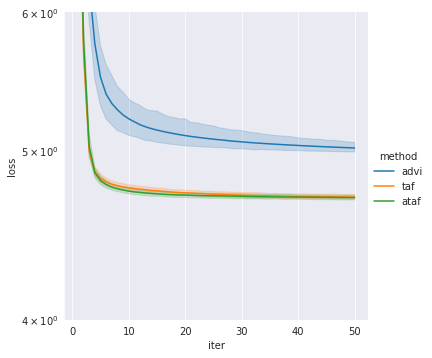

In [63]:
import pandas as pd
df_loss = pd.concat((pd.DataFrame({
    'loss': all_losses[trial][name],
    'iter': range(1,len(all_losses[trial][name])+1),
    'method': name,
    'trial': trial,
}) for trial in range(len(all_losses)) for name in all_losses[trial] if trial not in [4]), ignore_index=True)

import pickle
#pickle.dump(df_loss, open('df_loss.pkl', 'wb'))
#df_loss = pickle.load(open('df_loss.pkl', 'rb'))

#df_loss['log likelihood'] = -df_loss['loss']
g = sns.relplot(data=df_loss, kind='line', x='iter', y='loss', hue='method')
g.set(yscale='log', xlim=(None,None), ylim=(4,6))

In [64]:
df_loss[df_loss['iter'] == df_loss['iter'].max()].groupby('method').describe()

loss                                                              \
       count      mean       std       min       25%       50%       75%   
method                                                                     
advi     9.0  5.017509  0.055825  4.968398  4.989506  5.002154  5.025851   
ataf     9.0  4.699539  0.023760  4.667395  4.682950  4.691977  4.718335   
taf      9.0  4.702568  0.023277  4.681502  4.686745  4.698361  4.707820   

                  iter        ...             trial                           \
             max count  mean  ...   75%   max count      mean       std  min   
method                        ...                                              
advi    5.157227   9.0  50.0  ...  50.0  50.0   9.0  4.555556  3.205897  0.0   
ataf    4.732822   9.0  50.0  ...  50.0  50.0   9.0  4.555556  3.205897  0.0   
taf     4.755013   9.0  50.0  ...  50.0  50.0   9.0  4.555556  3.205897  0.0   

                            
        25%  50%  75%  max  
method                      
advi    2.0  5.0  7.0  9.0  
ataf    2.0  5.0  7.0  9.0  
taf     2.0  5.0  7.0  9.0  

[3 rows x 24 columns]

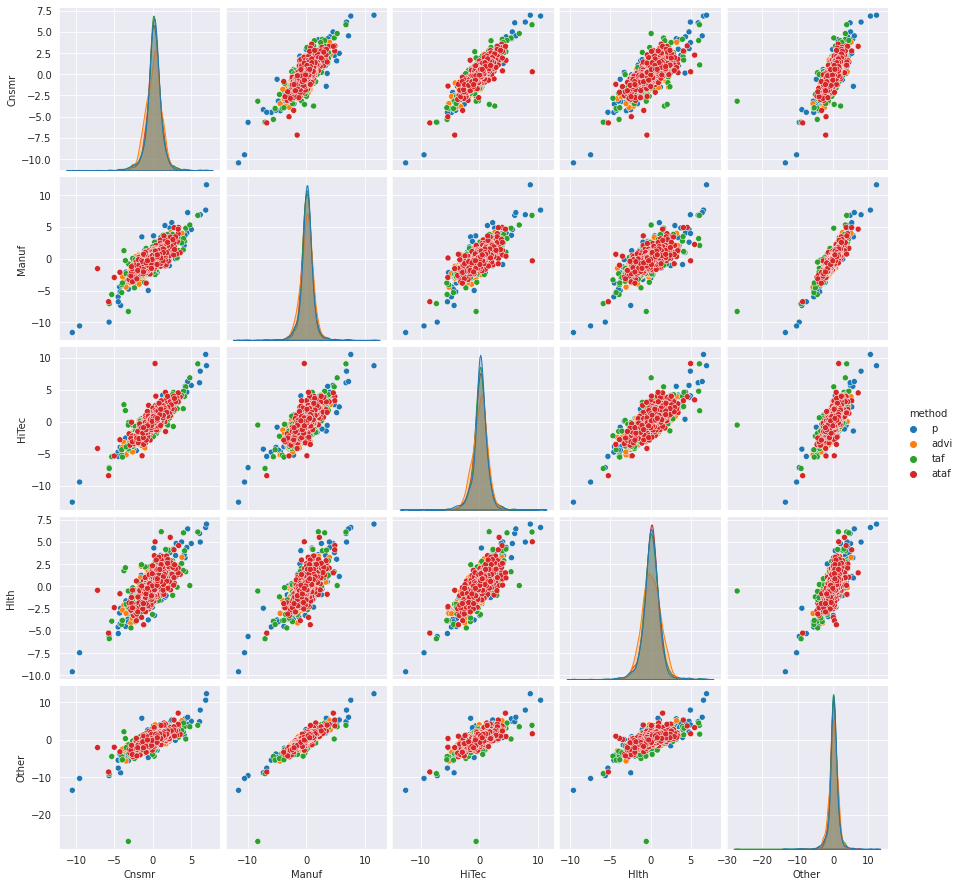

In [13]:
idx = -1
samples = all_samples[idx]

df = ds[0].copy()
df['method'] = 'p'
dfs = [df]
for name in samples:
    df = pd.DataFrame(samples[name].numpy(), columns=ds[0].columns)
    df['method'] = name
    dfs.append(df)
df_samples = pd.concat(dfs, ignore_index=True)

import pickle
#pickle.dump(df_samples, open('df_samples.pkl', 'wb'))
df_samples = pickle.load(open('df_samples.pkl', 'rb'))

sns.pairplot(
    data=df_samples,
    hue='method',
)

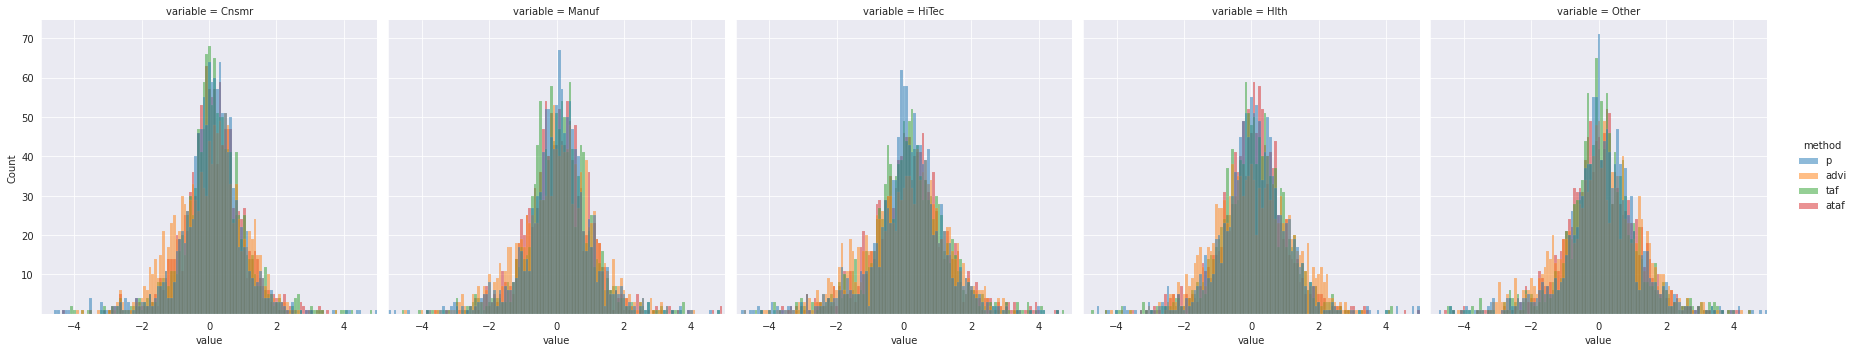

In [14]:
g = sns.displot(
    data=df_samples.melt(id_vars=["method"]),
    x='value', 
    hue="method", 
    kind='hist',
    col='variable',
)
g.set(xscale='linear', yscale='linear', ylim=(1e-8,None), xlim=(-5,5))

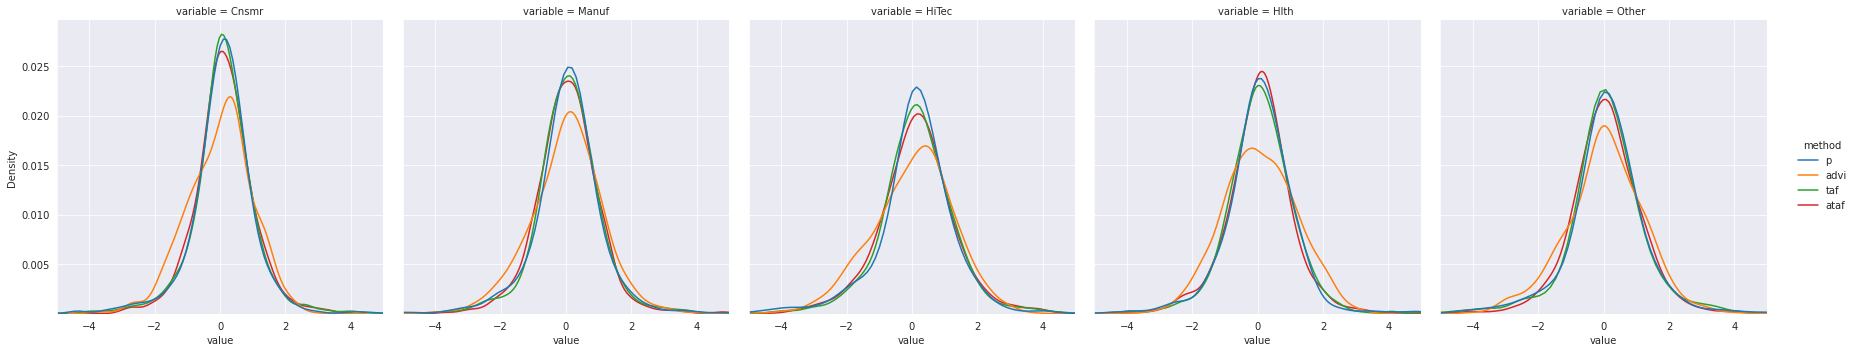

In [15]:
g = sns.displot(
    data=df_samples.melt(id_vars=["method"]),
    x='value', 
    hue="method", 
    kind='kde',
    col='variable',
)
g.set(xscale='linear', yscale='linear', ylim=(1e-8,None), xlim=(-5,5))

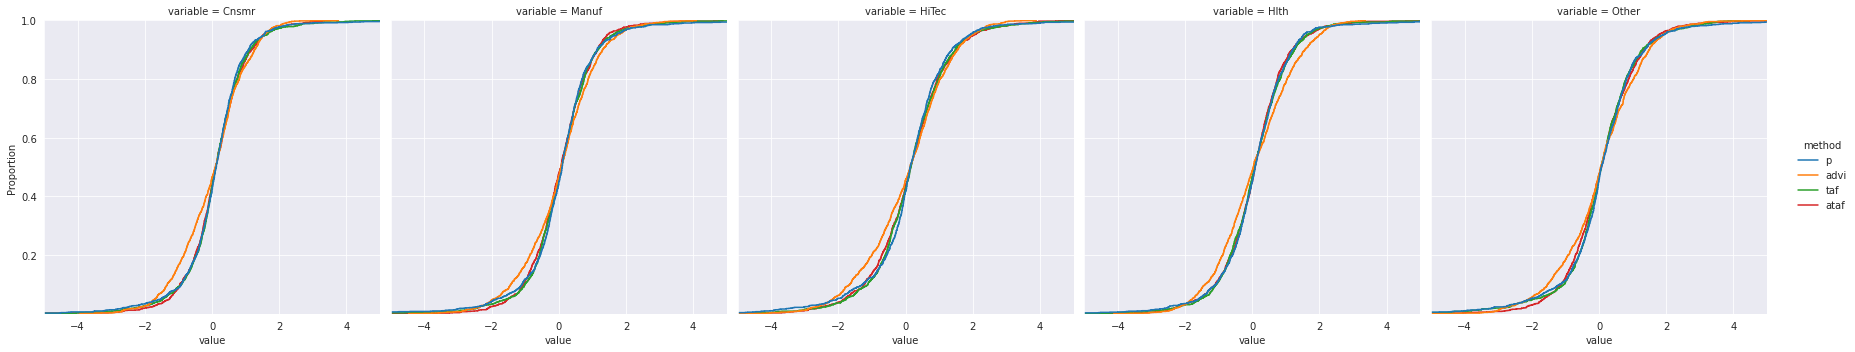

In [16]:
g = sns.displot(
    data=df_samples.melt(id_vars=["method"]),
    x='value', 
    hue="method", 
    kind='ecdf',
    col='variable',
)
g.set(xscale='linear', yscale='linear', ylim=(1e-8,None), xlim=(-5,5))